<a href="https://colab.research.google.com/github/moridin04/Data-Science-Project/blob/main/Data_Science_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Science - Course Project**

**Analyzing Factors Influencing Writing Productivity Through Machine Learning Models**

## **PHASE 1: Data Preparation**

### **Importing**

**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### **Dataset**

**Dataset**

In [2]:
url = "https://raw.githubusercontent.com/moridin04/Data-Science-Project/refs/heads/main/datascience-dataset-official.csv"

df = pd.read_csv(url)

In [3]:
df

,Week,Day,Date,Hours of Sleep,Hours of Reading Time,Book Titles,Authors,Genres,"Mood Impact (Happy, Neutral, Sad)",Did I write today?,Hours of Writing,Mode of Writing,Type of Day
0,1,1,12/14/25,7.6,2.0,Memories of Ice,Steven Erikson,Fantasy,Sad,Yes,2,Desktop,School
1,1,2,12/15/25,7.2,4.3,Memories of Ice,Steven Erikson,Fantasy,Happy,Yes,2,Phone,School
2,1,3,12/16/25,6.8,4.2,Memories of Ice,Steven Erikson,Fantasy,Neutral,No,0,NaN,School
3,1,4,12/17/25,8.1,0.0,NaN,NaN,NaN,Neutral,Yes,2,Phone,School
4,1,5,12/18/25,7.8,2.2,Memories of Ice,Steven Erikson,Fantasy,Happy,Yes,2,Desktop,School
5,1,6,12/19/25,7.1,1.0,11/23/66,Stephen King,Fiction,Happy,Yes,2,Desktop,School
6,1,7,12/20/25,8.9,0.0,NaN,NaN,NaN,Happy,Yes,2,Phone,School
7,2,8,12/21/25,7.8,0.0,NaN,NaN,NaN,Happy,Yes,2,Phone,School
8,2,9,12/22/25,7.7,1.0,House of Chains,Steven Eriskon,Fantasy,Happy,Yes,2,Phone,Vacation
9,2,10,12/23/25,6.8,1.0,On Writing,Stephen King,Memoir,Neutral,Yes,4,Phone,Vacation


**Columns**

In [4]:
df.columns

Index(['Week ', 'Day', 'Date', 'Hours of Sleep', 'Hours of Reading Time',
       'Book Titles', 'Authors', 'Genres', 'Mood Impact (Happy, Neutral, Sad)',
       'Did I write today?', 'Hours of Writing', 'Mode of Writing',
       'Type of Day'],
      dtype='object')

**Shape of Dataset**

In [5]:
df.shape

(56, 13)

**Numerical Features**

In [6]:
df.select_dtypes(include=['number']).columns

Index(['Week ', 'Day', 'Hours of Sleep', 'Hours of Reading Time',
       'Hours of Writing'],
      dtype='object')

**Categorical Features**

In [7]:
df.select_dtypes(include=['object']).columns

Index(['Date', 'Book Titles', 'Authors', 'Genres',
       'Mood Impact (Happy, Neutral, Sad)', 'Did I write today?',
       'Mode of Writing', 'Type of Day'],
      dtype='object')

**Describing the Dataset**

In [8]:
df.describe()

,Week,Day,Hours of Sleep,Hours of Reading Time,Hours of Writing
count,56.000000,56.000000,56.000000,56.000000,56.000000
mean,4.500000,28.500000,7.225000,1.196429,2.785714
std,2.312024,16.309506,0.998772,1.423563,1.744751
min,1.000000,1.000000,5.200000,0.000000,0.000000
25%,2.750000,14.750000,6.475000,0.000000,2.000000
50%,4.500000,28.500000,7.150000,1.000000,3.000000
75%,6.250000,42.250000,8.025000,2.000000,4.000000
max,8.000000,56.000000,9.100000,6.000000,7.000000


**Dataset Information**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Week                               56 non-null     int64  
 1   Day                                56 non-null     int64  
 2   Date                               56 non-null     object 
 3   Hours of Sleep                     56 non-null     float64
 4   Hours of Reading Time              56 non-null     float64
 5   Book Titles                        34 non-null     object 
 6   Authors                            34 non-null     object 
 7   Genres                             34 non-null     object 
 8   Mood Impact (Happy, Neutral, Sad)  56 non-null     object 
 9   Did I write today?                 56 non-null     object 
 10  Hours of Writing                   56 non-null     int64  
 11  Mode of Writing                    46 non-null     object 
 

## **PHASE 2: Exploratory Data Analysis (EDA)**

### **Cleaning**

**Structuring**

In [10]:
df.dtypes

,0
Week,int64
Day,int64
Date,object
Hours of Sleep,float64
Hours of Reading Time,float64
Book Titles,object
Authors,object
Genres,object
"Mood Impact (Happy, Neutral, Sad)",object
Did I write today?,object


**Indexing**

In [11]:
df.index

RangeIndex(start=0, stop=56, step=1)

**Duplication Check**

In [12]:
df.duplicated().sum()
df.shape

(56, 13)

**Conversion to Correct Data Types**

In [13]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

/tmp/ipython-input-748457276.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,0
Week,int64
Day,int64
Date,datetime64[ns]
Hours of Sleep,float64
Hours of Reading Time,float64
Book Titles,object
Authors,object
Genres,object
"Mood Impact (Happy, Neutral, Sad)",object
Did I write today?,object


In [14]:
df.head(10)

,Week,Day,Date,Hours of Sleep,Hours of Reading Time,Book Titles,Authors,Genres,"Mood Impact (Happy, Neutral, Sad)",Did I write today?,Hours of Writing,Mode of Writing,Type of Day
0,1,1,2025-12-14,7.6,2.0,Memories of Ice,Steven Erikson,Fantasy,Sad,Yes,2,Desktop,School
1,1,2,2025-12-15,7.2,4.3,Memories of Ice,Steven Erikson,Fantasy,Happy,Yes,2,Phone,School
2,1,3,2025-12-16,6.8,4.2,Memories of Ice,Steven Erikson,Fantasy,Neutral,No,0,NaN,School
3,1,4,2025-12-17,8.1,0.0,NaN,NaN,NaN,Neutral,Yes,2,Phone,School
4,1,5,2025-12-18,7.8,2.2,Memories of Ice,Steven Erikson,Fantasy,Happy,Yes,2,Desktop,School
5,1,6,2025-12-19,7.1,1.0,11/23/66,Stephen King,Fiction,Happy,Yes,2,Desktop,School
6,1,7,2025-12-20,8.9,0.0,NaN,NaN,NaN,Happy,Yes,2,Phone,School
7,2,8,2025-12-21,7.8,0.0,NaN,NaN,NaN,Happy,Yes,2,Phone,School
8,2,9,2025-12-22,7.7,1.0,House of Chains,Steven Eriskon,Fantasy,Happy,Yes,2,Phone,Vacation
9,2,10,2025-12-23,6.8,1.0,On Writing,Stephen King,Memoir,Neutral,Yes,4,Phone,Vacation


**Transforming Data**

In [15]:
df['Did I write today?'] = df['Did I write today?'].map({'Yes': 1, 'No': 0})
df.head()

,Week,Day,Date,Hours of Sleep,Hours of Reading Time,Book Titles,Authors,Genres,"Mood Impact (Happy, Neutral, Sad)",Did I write today?,Hours of Writing,Mode of Writing,Type of Day
0,1,1,2025-12-14,7.6,2.0,Memories of Ice,Steven Erikson,Fantasy,Sad,1,2,Desktop,School
1,1,2,2025-12-15,7.2,4.3,Memories of Ice,Steven Erikson,Fantasy,Happy,1,2,Phone,School
2,1,3,2025-12-16,6.8,4.2,Memories of Ice,Steven Erikson,Fantasy,Neutral,0,0,NaN,School
3,1,4,2025-12-17,8.1,0.0,NaN,NaN,NaN,Neutral,1,2,Phone,School
4,1,5,2025-12-18,7.8,2.2,Memories of Ice,Steven Erikson,Fantasy,Happy,1,2,Desktop,School


**Filling Null Values**

In [16]:
df.fillna(0, inplace=True)
print(df.to_string())

    Week   Day       Date  Hours of Sleep  Hours of Reading Time                                      Book Titles                                     Authors                   Genres Mood Impact (Happy, Neutral, Sad)  Did I write today?  Hours of Writing Mode of Writing Type of Day
0       1    1 2025-12-14             7.6                    2.0                                  Memories of Ice                              Steven Erikson                  Fantasy                               Sad                   1                 2         Desktop      School
1       1    2 2025-12-15             7.2                    4.3                                  Memories of Ice                              Steven Erikson                  Fantasy                             Happy                   1                 2           Phone      School
2       1    3 2025-12-16             6.8                    4.2                                  Memories of Ice                              Steven E

**Splitting Genres**

In [17]:
df['Genres'].str.split(', ')

,Genres
0,[Fantasy]
1,[Fantasy]
2,[Fantasy]
3,NaN
4,[Fantasy]
5,[Fiction]
6,NaN
7,NaN
8,[Fantasy]
9,[Memoir]


In [18]:
split_genres = df['Genres'].str.split(', ', expand=True)

In [19]:
df = pd.concat([df, split_genres], axis=1)
df = df.drop(columns=['Genres'])
df = df.rename(columns={0: 'Genre 1', 1: 'Genre 2', 2: 'Genre 3'})
df.head(10)

,Week,Day,Date,Hours of Sleep,Hours of Reading Time,Book Titles,Authors,"Mood Impact (Happy, Neutral, Sad)",Did I write today?,Hours of Writing,Mode of Writing,Type of Day,Genre 1,Genre 2,Genre 3
0,1,1,2025-12-14,7.6,2.0,Memories of Ice,Steven Erikson,Sad,1,2,Desktop,School,Fantasy,None,None
1,1,2,2025-12-15,7.2,4.3,Memories of Ice,Steven Erikson,Happy,1,2,Phone,School,Fantasy,None,None
2,1,3,2025-12-16,6.8,4.2,Memories of Ice,Steven Erikson,Neutral,0,0,0,School,Fantasy,None,None
3,1,4,2025-12-17,8.1,0.0,0,0,Neutral,1,2,Phone,School,NaN,NaN,NaN
4,1,5,2025-12-18,7.8,2.2,Memories of Ice,Steven Erikson,Happy,1,2,Desktop,School,Fantasy,None,None
5,1,6,2025-12-19,7.1,1.0,11/23/66,Stephen King,Happy,1,2,Desktop,School,Fiction,None,None
6,1,7,2025-12-20,8.9,0.0,0,0,Happy,1,2,Phone,School,NaN,NaN,NaN
7,2,8,2025-12-21,7.8,0.0,0,0,Happy,1,2,Phone,School,NaN,NaN,NaN
8,2,9,2025-12-22,7.7,1.0,House of Chains,Steven Eriskon,Happy,1,2,Phone,Vacation,Fantasy,None,None
9,2,10,2025-12-23,6.8,1.0,On Writing,Stephen King,Neutral,1,4,Phone,Vacation,Memoir,None,None


In [20]:
df_clean = df.copy()
genre_cols = ['Genre 1', 'Genre 2', 'Genre 3']
combined_genres = pd.get_dummies(df_clean[genre_cols].stack()).groupby(level=0).max().add_prefix('Genre_')

**Dropping Columns**

In [21]:
cols_to_drop = ['Week ', 'Date', 'Book Titles', 'Did I write today?', 'Authors', 'Genre 1', 'Genre 2', 'Genre 3']
existing_drops = [c for c in cols_to_drop if c in df_clean.columns]
df_clean = df_clean.drop(columns=existing_drops)
df_final = pd.concat([df_clean, combined_genres], axis=1)

**Encoding Categoricals**

In [22]:
categorical_cols = ['Mood Impact (Happy, Neutral, Sad)', 'Type of Day', 'Mode of Writing']
existing_cats = [c for c in categorical_cols if c in df_final.columns]
df_encoded = pd.get_dummies(df_final, columns=existing_cats, drop_first=True)
df_encoded = df_encoded.fillna(0)

In [23]:
target_variable = 'Hours of Writing'
correlations = df_encoded.corr()[target_variable].sort_values(ascending=False)

**Feature Correlation with "Hours of Writing" (Writing Productivity)**

Feature Correlation with 'Hours of Writing': 
Hours of Writing                             1.000000
Mode of Writing_Phone                        0.407816
Mode of Writing_Desktop                      0.215732
Day                                          0.203823
Genre_Shonen                                 0.121214
Genre_Memoir                                 0.094693
Mood Impact (Happy, Neutral, Sad)_Neutral    0.090517
Genre_Fantasy                                0.069743
Type of Day_Vacation                         0.047700
Mood Impact (Happy, Neutral, Sad)_Sad        0.029485
Genre_Fiction                               -0.016380
Hours of Reading Time                       -0.029595
Genre_Horror                                -0.033630
Type of Day_Weekend                         -0.126029
Hours of Sleep                              -0.298403
Name: Hours of Writing, dtype: float64


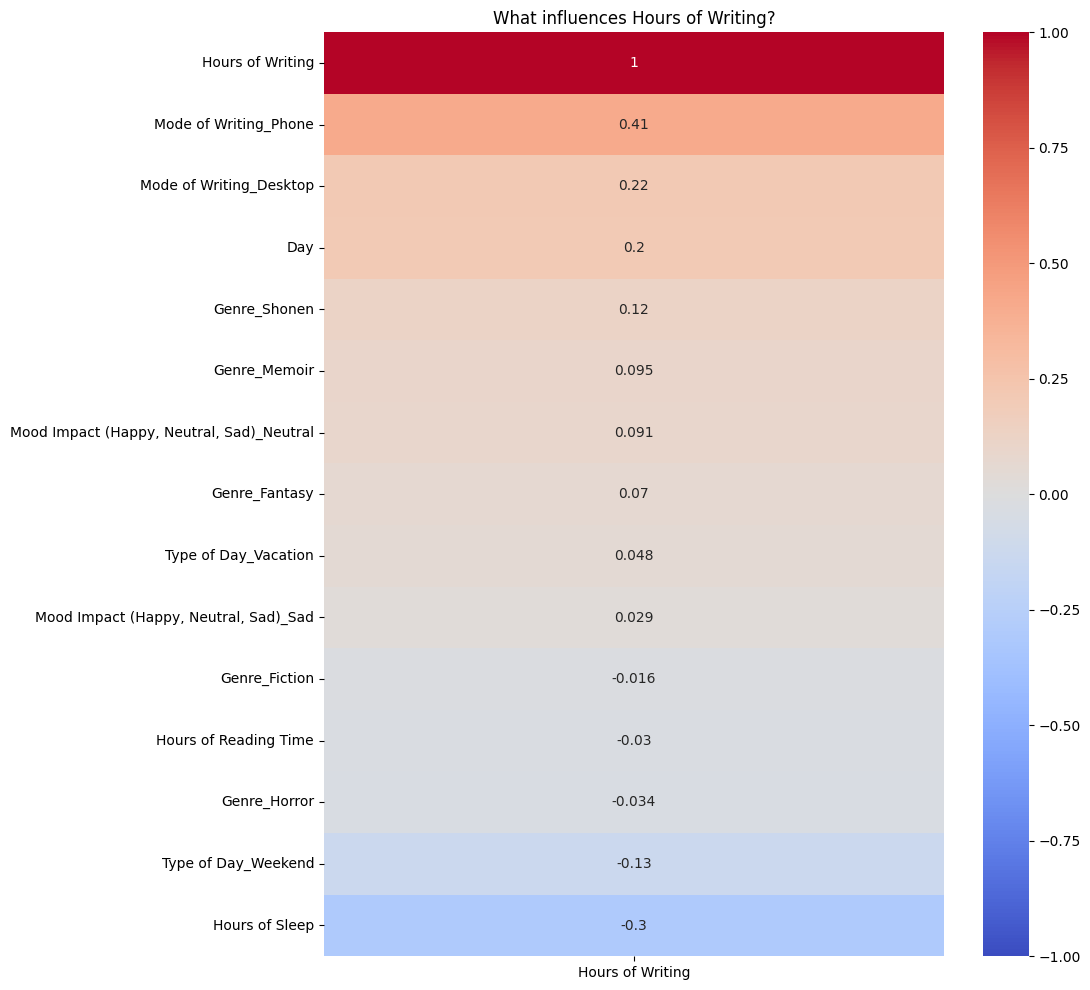

In [24]:
print("Feature Correlation with 'Hours of Writing': ")
print(correlations)
plt.figure(figsize=(10, 12))
heatmap_data = df_encoded.corr()[[target_variable]].sort_values(by=target_variable, ascending=False)
sns.heatmap(heatmap_data, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title(f"What influences {target_variable}?")
plt.show()

### Testing Features

All "Features" to be tested:
- Day (Line Plot) (done)
- Mode of Writing - (t-test) (done)
- Genre - (test) (done)
- Type of Day - (t-test) (done)
- Mood Impact (Happy, Neutral, Sad) - (ANOVA) (done)
- Hours of Reading Time - (Regression) (done)
- Hours of Sleep - (Regression) (done)

### Line Plot

**Research Question:** "Productivity Over Time (Day 1 to 56)"

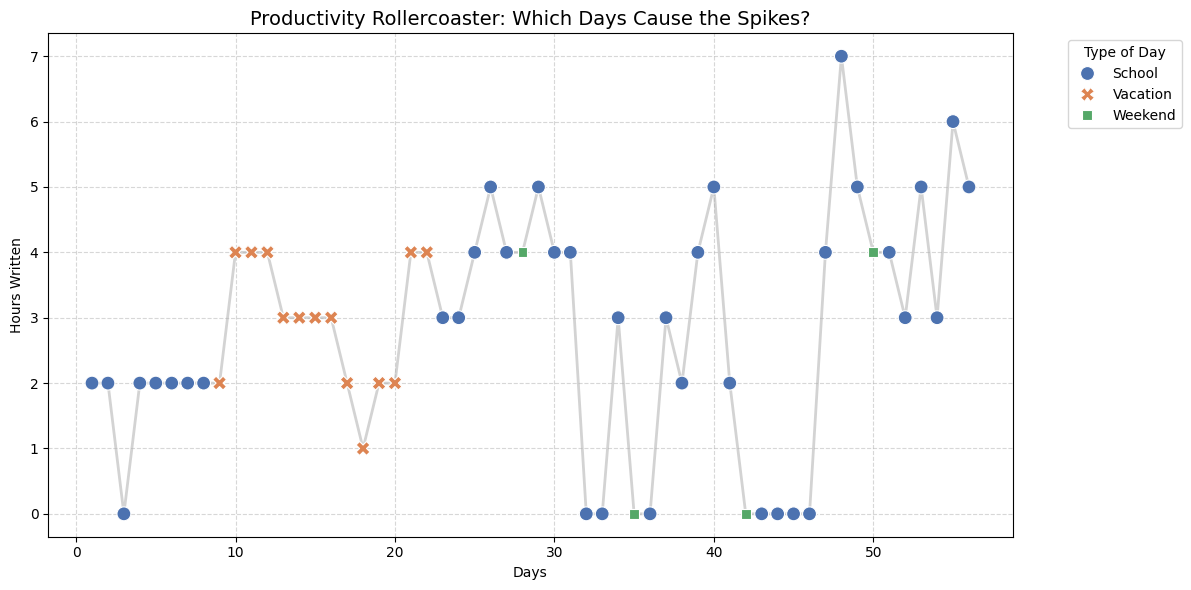

In [25]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Day', y='Hours of Writing', color='lightgray', linewidth=2, zorder=1)
sns.scatterplot(data=df, x='Day', y='Hours of Writing', hue='Type of Day', style='Type of Day', s=100, zorder=2, palette='deep')

plt.title("Productivity Rollercoaster: Which Days Cause the Spikes?", fontsize=14)
plt.xlabel("Days")
plt.ylabel("Hours Written")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Type of Day', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Research Answer (Analysis):**

**Interpretation:** My writing productivity over time (throughout Day 1 of recording to Day 56) undergoes a Wild Zig-Zag line, indicating that my writing habits are highly volatile.  

**Trend:** The line shows a slight upward trend, but has occasional periods of decline.

**Consistency:** Occasionally, the Hours of Writing dips into 0 or 1, showing that I struggle with being consistent. It has a tendency to show spikes of "high peaks" then plummets down to "low valleys" the next day. I interpret this as having bursts of writing inspirations.

**Impact of Day Types:**

**School:** Most of the "low points" are from "School Days", indicating that academic responsibilities affect my writing productivity.

**Vacation:** During vacation, where I have free time, I consistently produced average output, writing for 1-4 hours.

**Weekend:** Despite having free time during the weekends, I occasionally produced low to zero output, indicating that without the pressure of academic responsibilities, I may have spent the hours outside of writing.

### t-test

**Research Question:** "Which **Genres** boost my writing productivity the most?"

In [26]:
unique_genres = df[['Genre 1', 'Genre 2', 'Genre 3']].stack().unique()

In [27]:
print(f"{'GENRE':<15} | {'AVG (WITH)':<10} | {'AVG (WITHOUT)':<13} | {'P-VALUE':<10} | {'RESULT'}")
for genre in unique_genres:
    if genre == 0 or genre == '0': continue

    has_genre = df[['Genre 1', 'Genre 2', 'Genre 3']].apply(lambda x: genre in x.values, axis=1)

    with_genre = df[has_genre]['Hours of Writing']
    without_genre = df[~has_genre]['Hours of Writing']

    if len(with_genre) > 2:
        t_stat, p_val = ttest_ind(with_genre, without_genre, equal_var=False)
        sig = "SIGNIFICANT" if p_val < 0.05 else "NOT SIGNIFICANT"
        print(f"{genre:<15} | {with_genre.mean():<10.2f} | {without_genre.mean():<13.2f} | {p_val:<10.4f} | {sig}")

GENRE           | AVG (WITH) | AVG (WITHOUT) | P-VALUE    | RESULT
Fantasy         | 2.92       | 2.68          | 0.6124     | NOT SIGNIFICANT
Fiction         | 2.67       | 2.79          | 0.8724     | NOT SIGNIFICANT
Horror          | 2.60       | 2.80          | 0.8201     | NOT SIGNIFICANT
Shonen          | 3.67       | 2.74          | 0.4032     | NOT SIGNIFICANT


**Research Answer (Analysis):**

**Interpretation:**

On days that I read "Shonen", I wrote for 3.67 hours. On days that I didn't read "Shonen", I only wrote for 2.74 hours, which shows a +0.93 boost. With this data, my interpretation is that when I read "Shonen", I spend more hours on writing.

But all results are "Not Significant" due to their P-Values being less than Alpha (0.05). It indicates that the sample size per genre is too small.

All in all, "Shonen" and "Fantasy" both correlate with higher writing hours due to the difference boost, while "Horror" is the worst offender, correlated with lower writing hours.

### ANOVA

**Research Question:** "Does **Mood Impact** affect my writing?"

In [28]:
df['Mood Impact (Happy, Neutral, Sad)'].value_counts()

,count
"Mood Impact (Happy, Neutral, Sad)",
Happy,28
Neutral,25
Sad,3


In [29]:
df.groupby('Mood Impact (Happy, Neutral, Sad)').agg({'Hours of Writing': ['mean', 'median', 'min', 'max']})

Hours of Writing               
                                              mean median min max
Mood Impact (Happy, Neutral, Sad)                                
Happy                                     2.607143    2.5   0   6
Neutral                                   2.960000    4.0   0   5
Sad                                       3.000000    2.0   0   7

In [30]:
mood_happy = df[df['Mood Impact (Happy, Neutral, Sad)'] == 'Happy']['Hours of Writing']
mood_neutral = df[df['Mood Impact (Happy, Neutral, Sad)'] == 'Neutral']['Hours of Writing']
mood_sad = df[df['Mood Impact (Happy, Neutral, Sad)'] == 'Sad']['Hours of Writing']

f_statistic, p_value = stats.f_oneway(mood_happy, mood_neutral, mood_sad)
print(f"Happy Avg: {mood_happy.mean():.2f} | Neutral Avg: {mood_neutral.mean():.2f} | Sad Avg: {mood_sad.mean():.2f}")

print(f"F-statistic:, {f_statistic:.4f}")
print(f"P-Value:, {p_value:.4f}")
alpha = 0.05

Happy Avg: 2.61 | Neutral Avg: 2.96 | Sad Avg: 3.00
F-statistic:, 0.2864
P-Value:, 0.7521


In [31]:
if p_value < alpha:
  print("Significant different found: Mood Impact affects my writing.")
else:
  print("No significant difference found: I write, regardless of my mood.")

No significant difference found: I write, regardless of my mood.


**Research Answer (Analysis):**

**Interpretation:** Since the p_value is higher than the alpha value, it tells us that regardless of my mood (happy, neutral, sad), I can write.

### t-test

**Research Question:** "Does the "Mode of Writing" affect my writing productivity?"

In [32]:
phone_hours = df[df['Mode of Writing'] == 'Phone']['Hours of Writing']
desktop_hours = df[df['Mode of Writing'] == 'Desktop']['Hours of Writing']

In [33]:
t_stat, p_val = ttest_ind(phone_hours, desktop_hours, nan_policy='omit')

print(f"Phone avg: {phone_hours.mean():.2f} hrs | Desktop avg: {desktop_hours.mean():.2f} hrs")
print(f"p-value: {p_val:.4f}")
alpha = 0.05

Phone avg: 3.35 hrs | Desktop avg: 3.50 hrs
p-value: 0.7350


In [57]:
if p_value < alpha:
  print("Significant different found: The Mode of Writing affects my writing productivity.")
else:
  print("No significant difference found: I write, regardless of whether I use phone or desktop to write.")

No significant difference found: I write, regardless of whether I use phone or desktop to write.


**Research Answer (Analysis):**

**Interpretation:** Since the p_value is higher than the alpha value, it tells us that regardless of whether I use phone or desktop, I can still produce writing outputs.

### ANOVA

**Research Question:** "Is "Type of Day" associated with my writing productivity?"

In [35]:
vacation = df[df['Type of Day'] == 'Vacation']['Hours of Writing']
school = df[df['Type of Day'] == 'School']['Hours of Writing']
weekend = df[df['Type of Day'] == 'Weekend']['Hours of Writing']

In [36]:
f_statistic, p_val = stats.f_oneway(vacation, school, weekend)

print(f"School Avg: {school.mean():.2f} | Weekend Avg: {weekend.mean():.2f} | Vacation Avg: {vacation.mean():.2f}")
print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {p_val:.4f}")
alpha = 0.05

School Avg: 2.82 | Weekend Avg: 2.00 | Vacation Avg: 2.93
F-statistic: 0.4490
p-value: 0.6407


In [37]:
if p_value < alpha:
  print("Significant different found: The type of day matters.")
else:
  print("No significant difference found: I write, regardless of the type of day.")

No significant difference found: I write, regardless of the type of day.


**Research Answer (Analysis):**

**Interpretation:** Since the p_value is higher than the alpha value, it tells us that regardless of the type of day (school, weekday, vacation), I still write.

### Regression Plots

**Research Questions:**

"Hours of Sleep" VS "Writing"
"Hours of Reading Time" VS "Writing"

Text(0.5, 1.0, 'Regression Plot: READING TIME vs WRITING')

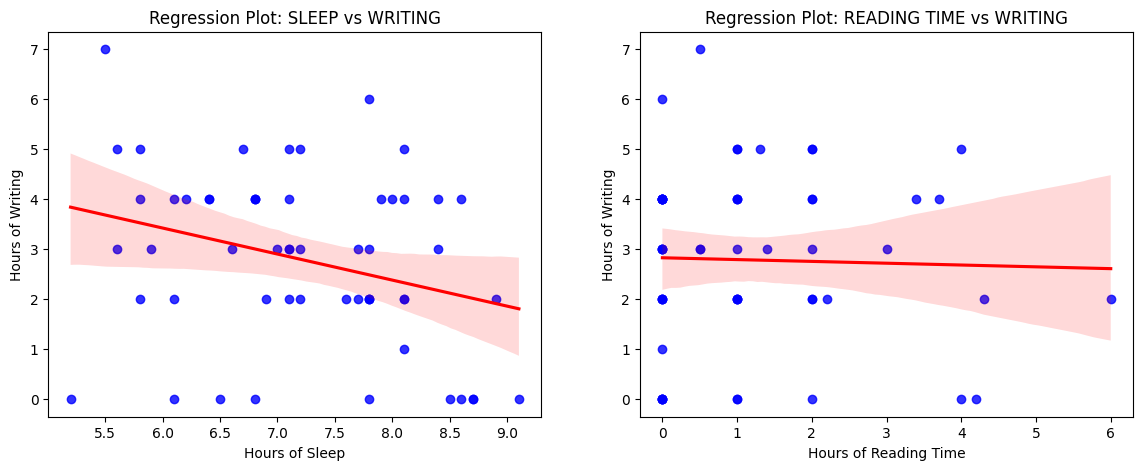

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.regplot(x='Hours of Sleep', y='Hours of Writing', data=df, ax=axes[0], color='blue', line_kws={'color':'red'})
axes[0].set_title("Regression Plot: SLEEP vs WRITING")
sns.regplot(x='Hours of Reading Time', y='Hours of Writing', data=df, ax=axes[1], color='blue', line_kws={'color':'red'})
axes[1].set_title("Regression Plot: READING TIME vs WRITING")

**Research Analysis:**

**"Hours of Sleep" VS "Writing":** The regression plot shows that "Hours of Sleep" and 'Hours of Writing" have a negative relationship. It indicates that the more I have hours spent on sleep, I have less hours dedicated to writing. My writing productivity seems to be at its highest when I have less hours of sleep.

**"Hours of Reading Time" VS "Writing":** The regression plot shows that "Hours of Reading Time" and "Hours of Writing" shows a positive correlation, where whenever I read more, I also write more, so I consider the "Reading" factor as a "fuel." Consuming content would mean I receive the inspiration necessary to drive me to dedicate hours on writing.



## **PHASE 3: Machine Learning**
Predicting Productivity

Select Features (X) and Target (y)

In [39]:
X = df_encoded.drop(columns=['Hours of Writing'])
y = df_encoded['Hours of Writing']

Train-Test Split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Feature Scaling (fit on Train, transform on Test)

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Linear Regression Model Training

In [42]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

Model Evaluation (RMSE, R^2)

In [43]:
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [44]:
print(f"Model Performance: ")
print(f"RMSE: On Average, predictions are off by {rmse:.2f} hours")
print(f"R-squared: {r2:.2f}")
print(f"R-squared: Explains {r2*100:.1f}% of the productivity variance")

Model Performance: 
RMSE: On Average, predictions are off by 1.06 hours
R-squared: 0.43
R-squared: Explains 43.4% of the productivity variance


**Root Mean Square Error:** Predictions are off by "1.06 hours", which is impressive for analyzing typically messy human behavior. It shows that it is generally accurate for prediction, making it a viable tool for estimating daily output.

**R-Squared:** The R-squared output is more than 0.40, which shows that it has understood nearly half of the writing habits. It proves that the factors are driving my writing productivity.



Visualization of Results

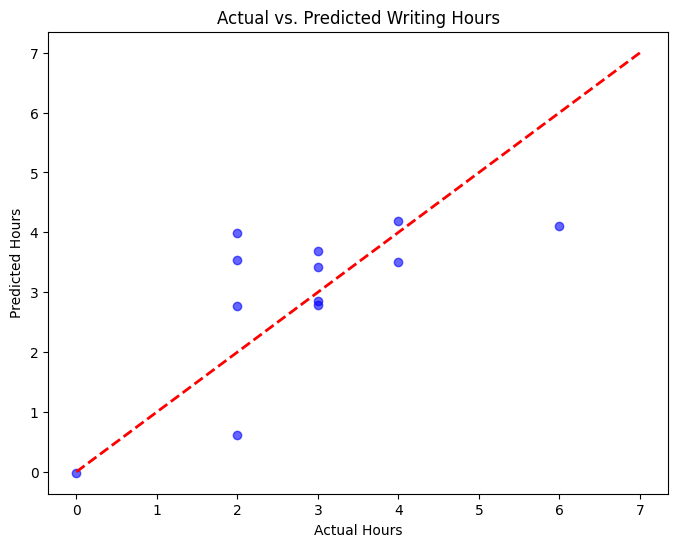

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Hours")
plt.ylabel("Predicted Hours")
plt.title("Actual vs. Predicted Writing Hours")
plt.show()

**Plot Analysis**

**Interpretation:** The "Actual vs. Predicted Writing Hours" scatterplot displays a clear positive diagonal upward trend - an ideal result for a regression model. The points follow the diagonal line, confirming that the model's predictions closely match reality. It does not guess randomly, rather it has learned the patterns in my writing habits.

**Consistency:** The points are clustered relatively tightly around the line, rather than forming a giant scattered cloud. This indicates that the model is consistent and that the RMSE (error rate) is low enough to be useful.

**Conclusion:** The model is reliable enough to be used for the predictive simulations in Phase 4.

## **PHASE 4: Interpreting the Model**

In [46]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})

In [47]:
coefficients['Impact'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Impact', ascending=False)

In [48]:
print("Factor Importance (Model Coefficients)")
print(coefficients[['Feature', 'Impact']])


Factor Importance (Model Coefficients)
                                      Feature    Impact
13                      Mode of Writing_Phone  1.922543
12                    Mode of Writing_Desktop  1.652063
0                                         Day  0.493378
4                               Genre_Fiction  0.470534
9       Mood Impact (Happy, Neutral, Sad)_Sad  0.301281
7                                Genre_Shonen  0.185884
2                       Hours of Reading Time  0.164888
8   Mood Impact (Happy, Neutral, Sad)_Neutral  0.142160
6                                Genre_Memoir  0.133325
3                               Genre_Fantasy  0.131857
11                        Type of Day_Weekend  0.117799
1                              Hours of Sleep  0.042428
5                                Genre_Horror  0.008092
10                       Type of Day_Vacation  0.006645


/tmp/ipython-input-8085914.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefficients, x='Impact', y='Feature', palette='viridis')


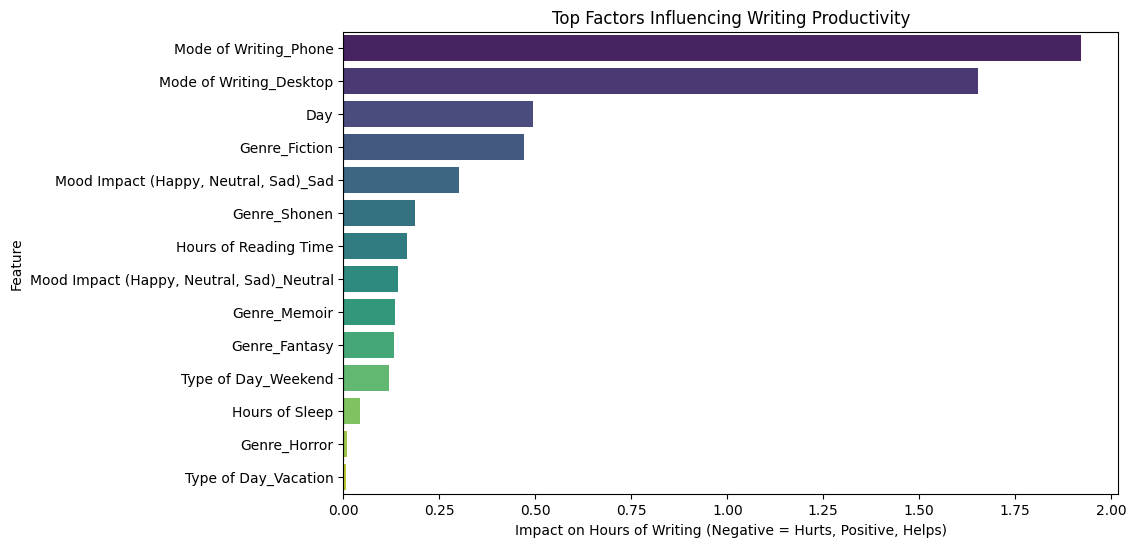

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(data=coefficients, x='Impact', y='Feature', palette='viridis')
plt.title("Top Factors Influencing Writing Productivity")
plt.xlabel("Impact on Hours of Writing (Negative = Hurts, Positive, Helps)")
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

Predicting Scenarios to Improve Writing Productivity

In [50]:
scenarios = pd.DataFrame([
    # Scenario A: Speed Writing
    # Writing on my Phone, feeling Happy on a School day, while planning to read / having read "Shonen" works
    # having done Moderate Reading, and having Low Sleep
    {'Mode of Writing_Phone': 1, 'Mode of Writing_Desktop': 0,
     'Genre_Shonen': 1, 'Genre_Fantasy': 0, 'Genre_Horror': 0,
     'Mood Impact (Happy, Neutral, Sad)_Happy': 1, 'Mood Impact (Happy, Neutral, Sad)_Neutral': 0, 'Mood Impact (Happy, Neutral, Sad)_Sad': 0,
     'Type of Day_School': 1, 'Type of Day_Vacation': 0, 'Type of Day_Weekend': 0,
     'Hours of Sleep': 5, 'Hours of Reading Time': 2, 'Day': 60},

    # Scenario B: Cozy Writing
    # Writing on the Desktop, feeling Neutral on a Weekend day, while planning to read / having read "Fantasy" works
    # having done High Reading, and having Perfect Sleep
    {'Mode of Writing_Phone': 0, 'Mode of Writing_Desktop': 1,
     'Genre_Shonen': 0, 'Genre_Fantasy': 1, 'Genre_Horror': 0,
     'Mood Impact (Happy, Neutral, Sad)_Happy': 0, 'Mood Impact (Happy, Neutral, Sad)_Neutral': 1, 'Mood Impact (Happy, Neutral, Sad)_Sad': 0,
     'Type of Day_School': 0, 'Type of Day_Vacation': 0, 'Type of Day_Weekend': 1,
     'Hours of Sleep': 8, 'Hours of Reading Time': 4, 'Day': 60},

    # Scenario C: Horrible Writing
    # Writing on the Desktop, feeling Sad on a Vacation day, while planning to read / having read "Horror" works
    # having done No Reading, and having Overslept
    {'Mode of Writing_Phone': 0, 'Mode of Writing_Desktop': 1,
     'Genre_Shonen': 0, 'Genre_Fantasy': 0, 'Genre_Horror': 1,
     'Mood Impact (Happy, Neutral, Sad)_Happy': 0, 'Mood Impact (Happy, Neutral, Sad)_Neutral': 0, 'Mood Impact (Happy, Neutral, Sad)_Sad': 1,
     'Type of Day_School': 0, 'Type of Day_Vacation': 1, 'Type of Day_Weekend': 0,
     'Hours of Sleep': 11, 'Hours of Reading Time': 0, 'Day': 60}
])

In [51]:
scenarios = pd.get_dummies(scenarios)
scenarios = scenarios.reindex(columns=X.columns, fill_value=0)
scenarios

,Day,Hours of Sleep,Hours of Reading Time,Genre_Fantasy,Genre_Fiction,Genre_Horror,Genre_Memoir,Genre_Shonen,"Mood Impact (Happy, Neutral, Sad)_Neutral","Mood Impact (Happy, Neutral, Sad)_Sad",Type of Day_Vacation,Type of Day_Weekend,Mode of Writing_Desktop,Mode of Writing_Phone
0,60,5,2,0,0,0,0,1,0,0,0,0,0,1
1,60,8,4,1,0,0,0,0,1,0,0,1,1,0
2,60,11,0,0,0,1,0,0,0,1,1,0,1,0


In [52]:
scenarios_scaled = scaler.transform(scenarios)

Predictive Simulation to Improve Productivity

In [53]:
predictions = model.predict(scenarios_scaled)

print("Predictive Simulation")
print(f"Scenario A (Speed Writing): {predictions[0]:.2f} Hours of Writing")
print(f"Scenario B (Cozy Writing):   {predictions[1]:.2f} Hours of Writing")
print(f"Scenario C (Horrible Writing): {predictions[2]:.2f} Hours of Writing")

Predictive Simulation
Scenario A (Speed Writing): 5.35 Hours of Writing
Scenario B (Cozy Writing):   5.32 Hours of Writing
Scenario C (Horrible Writing): 5.73 Hours of Writing


Showcasing Breakdown of Predictive Simulation

In [54]:
coeffs = model.coef_
feature_names = X.columns

In [55]:
breakdown = []
for i, row in enumerate(scenarios_scaled):
  contribution = row * coeffs
  scen_data = {'Scenario': f"Scenario {chr(65+i)}"}
  for feat, val in zip(feature_names, contribution):
    scen_data[feat] = val

  scen_data['Baseline (Intercept)'] = model.intercept_

  breakdown.append(scen_data)

df_breakdown = pd.DataFrame(breakdown).set_index('Scenario')

plot_data = pd.DataFrame(index=df_breakdown.index)
plot_data['Mode'] = df_breakdown.filter(like='Mode').sum(axis=1)
plot_data['Genre'] = df_breakdown.filter(like='Genre').sum(axis=1)
plot_data['Mood'] = df_breakdown.filter(like='Mood').sum(axis=1)
plot_data['Day Type'] = df_breakdown.filter(like='Day Type').sum(axis=1)
plot_data['Sleep'] = df_breakdown['Hours of Sleep']
plot_data['Reading'] = df_breakdown['Hours of Reading Time']
plot_data['Baseline'] = df_breakdown['Baseline (Intercept)']

<Figure size 1200x700 with 0 Axes>

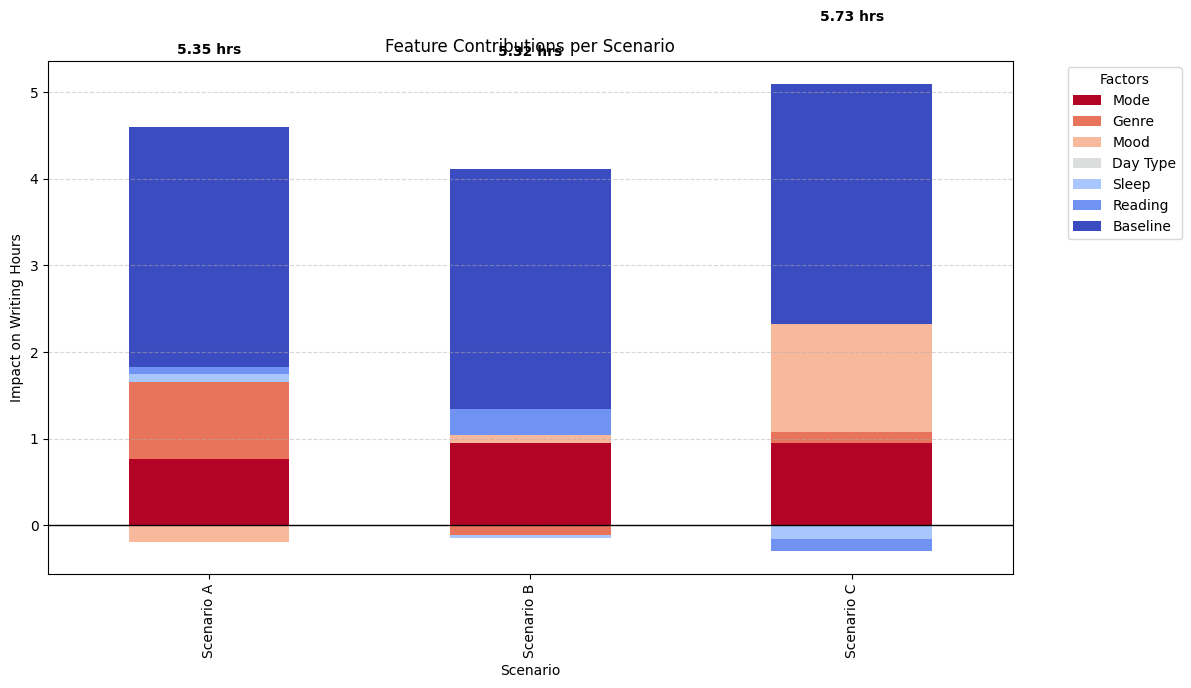

In [56]:
plt.figure(figsize=(12, 7))
plot_data.plot(kind='bar', stacked=True, colormap='coolwarm_r', figsize=(12, 7))
plt.title("Feature Contributions per Scenario")
plt.ylabel("Impact on Writing Hours")
plt.xlabel("Scenario")
plt.axhline(0, color='black', linewidth=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Factors")
plt.grid(axis='y', linestyle='--', alpha=0.5)

totals = predictions
for i, total in enumerate(totals):
  plt.text(i, total + 0.1, f"{total:.2f} hrs", ha='center', weight='bold')

plt.tight_layout()
plt.show()